In [1]:
import h5py
import numpy as np
import torch, monai
import torchio as tio
from typing import Sequence
from monai.data import ArrayDataset, DataLoader, PersistentDataset
from monai.transforms import Compose, RandAffine, Rand2DElastic, Rand3DElastic
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
import nibabel as nib
from utils import *

import glob, os
from monai.transforms import (
    Compose,
    LoadImage,
    RandSpatialCrop,
    ScaleIntensity,
    RandFlip,
    RandRotate90
)

from monai.utils import first
from tqdm import tqdm
from utils import *


## 1. Create Dataloader

In [2]:
root_dir = 'datasets/IXI/train'

t1s = sorted(glob.glob(os.path.join(root_dir, "t1*.npy")))
t2s = sorted(glob.glob(os.path.join(root_dir, "t2*.npy")))

t1_trans = Compose(
        [
            LoadImage(image_only=True, ensure_channel_first=True),
            RandSpatialCrop((96, 96), random_size=False),
            RandFlip(prob=0.5, spatial_axis=0),
            RandFlip(prob=0.5, spatial_axis=1),
            RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        ]
    )

t2_trans = Compose(
        [
            LoadImage(image_only=True, ensure_channel_first=True),
            RandSpatialCrop((96, 96), random_size=False),
            RandFlip(prob=0.5, spatial_axis=0),
            RandFlip(prob=0.5, spatial_axis=1),
            RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        ]
    )


# define array dataset, data loader
train_ds = ArrayDataset(t1s, t1_trans, t2s, t2_trans)
train_loader = DataLoader(train_ds, batch_size=30, num_workers=5, shuffle=True, pin_memory=torch.cuda.is_available())
# This is the trainloader


In [3]:
root_dir = 'datasets/IXI/val'

t1s = sorted(glob.glob(os.path.join(root_dir, "t1*.npy")))
t2s = sorted(glob.glob(os.path.join(root_dir, "t2*.npy")))

t1_trans = Compose(
        [
            LoadImage(image_only=True, ensure_channel_first=True),
        ]
    )

t2_trans = Compose(
        [
            LoadImage(image_only=True, ensure_channel_first=True),
        ]
    )


# define array dataset, data loader
val_ds = ArrayDataset(t1s, t1_trans, t2s, t2_trans)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=5, shuffle=True, pin_memory=torch.cuda.is_available())
# This is the val_loader


## 2. Make original? (PGAN) model

In [ ]:
class Args:
    pass

opt = {'isTrain':True, 'input_nc':1, 'output_nc':1, 'ngf':16, 'ndf':16, 
       'n_layers_D':3, 'norm':'instance','no_dropout':True,'no_lsgan':True, 'init_type':'normal', 
       'gpu_ids':[0], 'checkpoints_dir':'checkpoints', 'name':'Test', 'lambda_vgg':10.0,
       'continue_train':False, 'pool_size':0, 'lr':0.0002, 'beta1':0.5, 'lambda_adv':0.1, 'lambda_A':10.0, 'lmbda_B':10.0, 'lambda_identity':0.0,
       'lr_policy':'lambda', 'epoch_count':1, 'niter':100, 'niter_decay':100, 'which_direction':'AtoB', 'dataroot':'datasets/IXI/train'}
args = Args()
for key, value in opt.items():
    setattr(args, key, value)

from models import create_model
from models.pgan_model import pGAN

model = pGAN()  
model.initialize(args)

## 3. Run training (Epoch by Epoch)

In [ ]:

for epoch in range(1000):
    # Training Stage
    for i, (t1, t2) in enumerate(train_loader): # Train images with patch 96x96
        model.set_input({'A':t1, 'B':t2})
        model.optimize_parameters()
        
    if epoch % 10 == 0:
        # Validation Stage
        psnr, ssim = 0, 0
        for i, (t1, t2) in enumerate(val_loader): # Test it with full FOV
            model.set_input({'A':t1, 'B':t2})
            _psnr, _ssim = model.test()
            psnr += _psnr
            ssim += _ssim
            if i == 0:
                out = model.get_current_visuals()
                plot_images([out['real_A'], out['fake_B'], out['real_B']], ['Real_A', 'Fake_B', 'Real_B'])
        print(f"Epoch {epoch}, Iter {i}, PSNR {psnr/len(val_loader)}, SSIM {ssim/len(val_loader)}")


## 4. Modify the network with monai.GenerativeModels
See `https://github.com/Project-MONAI/GenerativeModels/blob/main/tutorials/generative/2d_autoencoderkl/2d_autoencoderkl_tutorial.ipynb`

In [5]:
from generative.losses import PatchAdversarialLoss, PerceptualLoss
from generative.networks.nets import AutoencoderKL, PatchDiscriminator
from monai.config import print_config
from monai.networks.nets import AttentionUnet
from torch.nn import L1Loss
from tqdm import tqdm
from monai.networks.layers import Act
from collections import OrderedDict

import time
from generative.losses import PatchAdversarialLoss, PerceptualLoss
from generative.networks.nets import AutoencoderKL, PatchDiscriminator
print_config()

MONAI version: 1.1.0
Numpy version: 1.24.3
Pytorch version: 2.0.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/kanghyun/miniconda3/envs/misalign/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: 0.20.0
Pillow version: 9.5.0
Tensorboard version: 2.13.0
gdown version: 4.7.1
TorchVision version: 0.15.2+cu118
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: 1.1.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

model = AttentionUnet(spatial_dims=2, in_channels=1, out_channels=1, channels=[32,64,128,256], strides=[1,2,2,2]) # Strides: downsampling layers
model.to(device)

discriminator = PatchDiscriminator(
    spatial_dims=2,
    num_layers_d=3,
    num_channels=64,
    in_channels=1,
    out_channels=1,
    kernel_size=4,
    activation=(Act.LEAKYRELU, {"negative_slope": 0.2}),
    norm="BATCH",
    bias=False,
    padding=1,
)
discriminator.to(device)

perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="radimagenet_resnet50")
perceptual_loss.to(device)

optimizer_g = torch.optim.Adam(params=model.parameters(), lr=1e-4)
optimizer_d = torch.optim.Adam(params=discriminator.parameters(), lr=5e-4)

l1_loss = L1Loss()
adv_loss = PatchAdversarialLoss(criterion="least_squares")
adv_weight = 0.01
perceptual_weight = 0.001

# PGAN : l1_loss + adv_loss + perceptual_loss

Using cuda


In [7]:
import util.util as util

def get_current_visuals(real_A,fake_B,real_B):
    real_A = util.tensor2im(real_A.data) # 코드에 차원 안맞는 에러가 있어서 수정해줌
    fake_B = util.tensor2im(fake_B.data)
    real_B = util.tensor2im(real_B.data)
    # 모두 [1,1,256,256]
    return OrderedDict([('real_A', real_A), ('fake_B', fake_B), ('real_B', real_B)])

Epoch 0:   0%|                                                                         | 0/76 [00:00<?, ?it/s]/home/kanghyun/miniconda3/envs/misalign/lib/python3.9/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/home/kanghyun/miniconda3/envs/misalign/lib/python3.9/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/home/kanghyun/miniconda3/envs/misalign/lib/python3.9/site-packages/torch/_ten

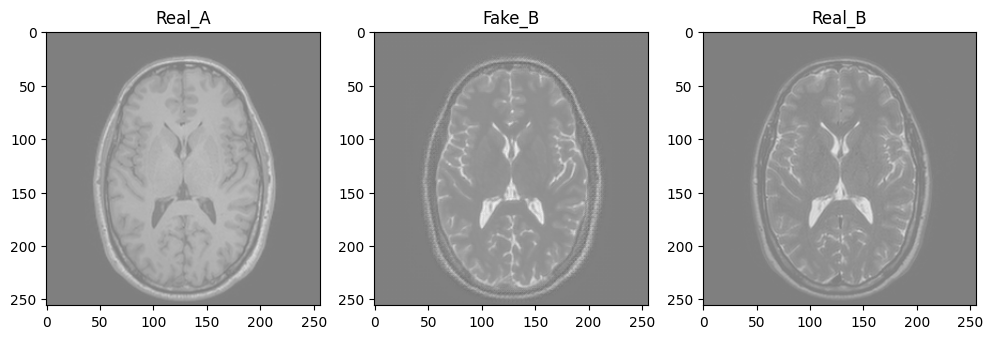

Epoch 19: 100%|██████████| 76/76 [00:08<00:00,  9.07it/s, recons_loss=0.0401, gen_loss=0.369, disc_loss=0.248]


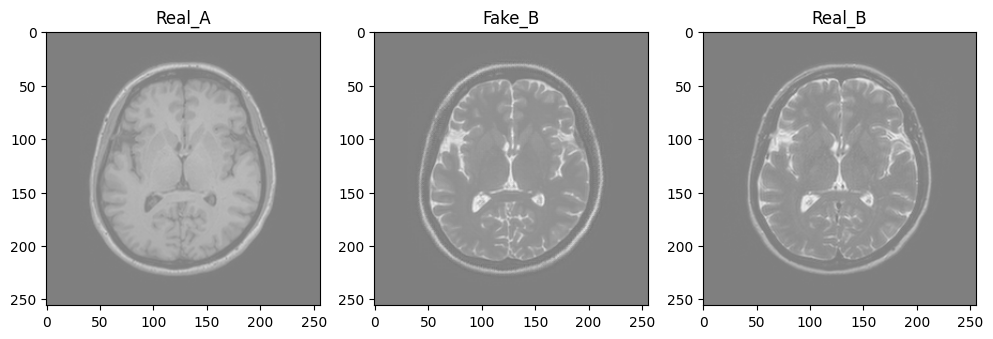

Epoch 29: 100%|███████████| 76/76 [00:08<00:00,  9.06it/s, recons_loss=0.038, gen_loss=0.98, disc_loss=0.0424]


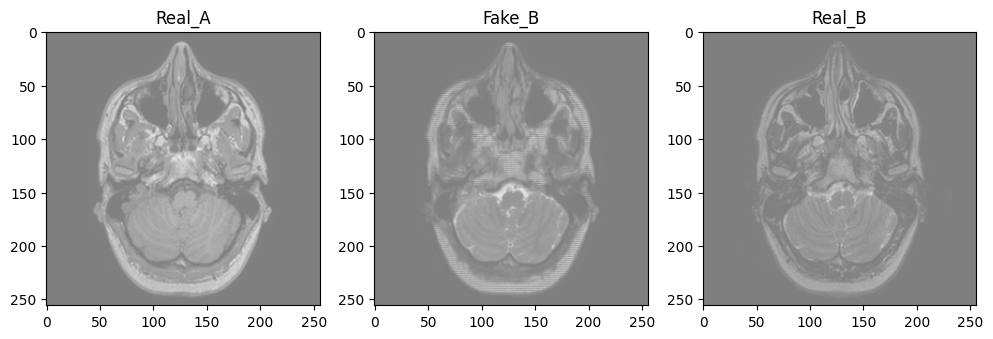

Epoch 39: 100%|██████████| 76/76 [00:08<00:00,  9.22it/s, recons_loss=0.0369, gen_loss=0.279, disc_loss=0.248]


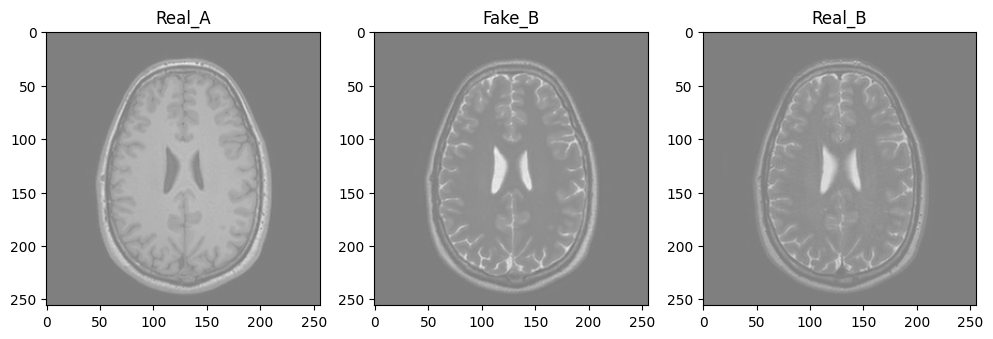

Epoch 49: 100%|██████████| 76/76 [00:08<00:00,  9.27it/s, recons_loss=0.0365, gen_loss=0.358, disc_loss=0.221]


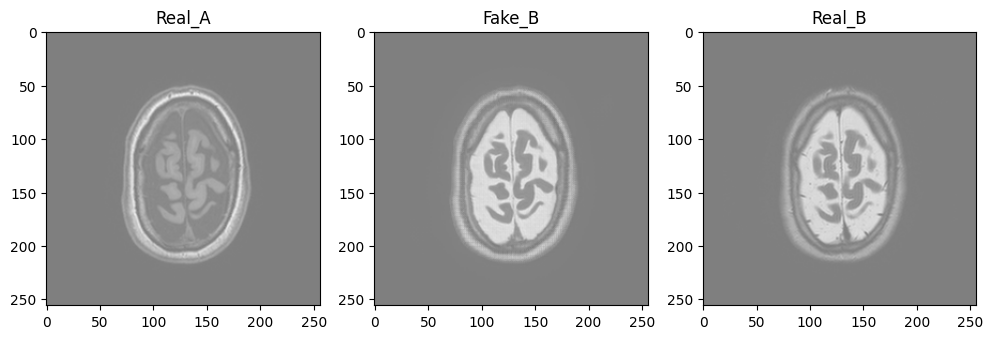

Epoch 53:  51%|█████▏    | 39/76 [00:04<00:04,  9.13it/s, recons_loss=0.0362, gen_loss=0.805, disc_loss=0.121]


KeyboardInterrupt: 

In [8]:
# Example from : https://github.com/Project-MONAI/GenerativeModels/blob/main/tutorials/generative/2d_autoencoderkl/2d_autoencoderkl_tutorial.ipynb

n_epochs = 500
val_interval = 10
epoch_recon_loss_list = []
epoch_gen_loss_list = []
epoch_disc_loss_list = []
val_recon_epoch_loss_list = []
intermediary_images = []
n_example_images = 4

total_start = time.time()
for epoch in range(n_epochs):
    model.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, (t1,t2) in progress_bar:
        t1 = t1.to(device)
        t2 = t2.to(device)
        optimizer_g.zero_grad(set_to_none=True)

        reconstruction = model(t1)

        recons_loss = l1_loss(reconstruction.float(), t2.float()) # L1 loss

        logits_fake = discriminator(reconstruction.contiguous().float())[-1]
        p_loss = perceptual_loss(reconstruction.float(), t2.float()) # Perceptual loss
        generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False) # Adversarial loss
        loss_g = recons_loss + perceptual_weight * p_loss + adv_weight * generator_loss

        loss_g.backward()
        optimizer_g.step()

        # Discriminator part (Updating discriminator)
        optimizer_d.zero_grad(set_to_none=True)

        logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
        loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
        logits_real = discriminator(t2.contiguous().detach())[-1]
        loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
        discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

        loss_d = adv_weight * discriminator_loss

        loss_d.backward()
        optimizer_d.step() # Updating discriminator

        epoch_loss += recons_loss.item()
        gen_epoch_loss += generator_loss.item()
        disc_epoch_loss += discriminator_loss.item()

        progress_bar.set_postfix(
            {
                "recons_loss": epoch_loss / (step + 1),
                "gen_loss": gen_epoch_loss / (step + 1),
                "disc_loss": disc_epoch_loss / (step + 1),
            }
        )
    epoch_recon_loss_list.append(epoch_loss / (step + 1))
    epoch_gen_loss_list.append(gen_epoch_loss / (step + 1))
    epoch_disc_loss_list.append(disc_epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, (t1,t2) in enumerate(val_loader, start=1):
                t1 = t1.to(device)
                t2 = t2.to(device)
                reconstruction = model(t1)

                # get the first sammple from the first validation batch for visualisation
                # purposes
                recons_loss = l1_loss(reconstruction.float(), t2.float())

                val_loss += recons_loss.item()
                if val_step == 1:
                    intermediary_images.append(reconstruction[:n_example_images, 0])
                    out = get_current_visuals(t1.float(),reconstruction.float(),t2.float())
                    plot_images([out['real_A'], out['fake_B'], out['real_B']], ['Real_A', 'Fake_B', 'Real_B'])

        val_loss /= val_step
        val_recon_epoch_loss_list.append(val_loss)

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

In [ ]:
# TODO: Step2_PGAN.ipynb -> Step2_PGAN_daniel.ipynb 로 정리

# TODO: Add scaling the images (too grayish)
# TODO: Make CycleGAN model, L1-loss model
# TODO: Make this into a script (train.py)
# TODO: Add saving PSNR & SSIM

# TODO: train_pgan.py, train_cgan.py, train_l1loss.py 로 정리
# TODO: evaluate.ipynb


In [ ]:
print(out.shape, t2.shape)

In [ ]:
print(model)